In [16]:
# set up a test subject
micapipe_dir = '/data/mica3/BIDS_MICs/derivatives/micapipe'
hippunfold_dir = '/data/mica3/BIDS_MICs/derivatives/hippunfold_v1.0.0/hippunfold'

subject = 'HC002'
session = '01'
hemi = ['L','R']
label = ['hipp','dentate'] #the dentate gyrus is given a separate surface. Here we will include it but this is optional.

!mkdir -p tmp # make a temporary directory for storing files

## 0) Map fMRI data onto a hippocampal surface

First we will map rsfMRI timeseries data onto a hippocampal surface, and then load the data and plot it. For a full walkthrough of this step, see https://github.com/jordandekraker/hippunfold_toolbox/blob/main/tutorial_fMRI.ipynb

In [2]:
# transform fMRI data to space-nativepro
xfm1 = f'{micapipe_dir}/sub-{subject}/ses-{session}/xfm/sub-{subject}_ses-{session}'\
    f'_rsfmri_from-rsfmri_to-nativepro_mode-image_desc-affine_0GenericAffine.mat'
ref = '/data_/mica1/01_programs/micapipe/MNI152Volumes/MNI152_T1_2mm.nii.gz'
cmd = f' antsApplyTransforms -d 3 -e 3 '\
    f'-r {ref} '\
    f'-i {micapipe_dir}/sub-{subject}/ses-{session}/func/volumetric/sub-{subject}_ses-{session}_space-rsfmri_desc-singleecho_clean.nii.gz '\
    f'-t {xfm1} '\
    f'-o tmp/sub-{subject}_ses-{session}_space-nativepro_rsfmri.nii.gz '
!{cmd}

# sample data along hippocampal surfaces
for h in range(len(hemi)):
    for l in range(len(label)):
        cmd = f'wb_command -volume-to-surface-mapping '\
            f'tmp/sub-{subject}_ses-{session}_space-nativepro_rsfmri.nii.gz '\
            f'{hippunfold_dir}/sub-{subject}/surf/sub-{subject}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_midthickness.surf.gii '\
            f'tmp/sub-{subject}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_desc-rsmfri.func.gii '\
            f'-enclosing'
        !{cmd}

# (optional) smooth data
sigma = 2 #Gaussian smoothing kernal sigma (mm)
for h in range(len(hemi)):
    for l in range(len(label)):
        cmd = f'wb_command -metric-smoothing '\
            f'{hippunfold_dir}/sub-{subject}/surf/sub-{subject}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_midthickness.surf.gii '\
            f'tmp/sub-{subject}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_desc-rsmfri.func.gii '\
            f'{sigma} '\
            f'tmp/sub-{subject}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_desc-rsmfri_smooth.func.gii'
        !{cmd}


<Axes3DSubplot:>

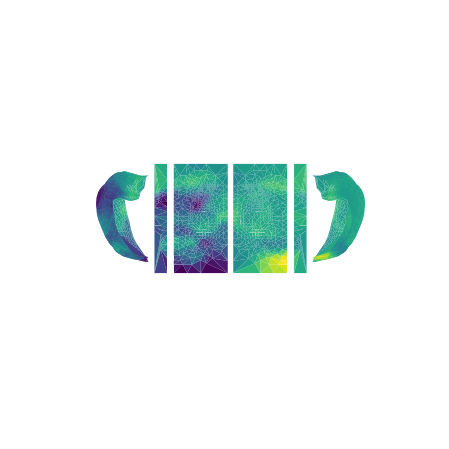

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

import sys
sys.path.insert(1, '/export03/data/opt/hippunfold_toolbox/hippunfold_toolbox')
import plotting
import utils

# load the hippocampal functional data
hipp_func = np.array([])
for h in range(len(hemi)):
    for l in range(len(label)):
        f = nib.load(f'tmp/sub-{subject}_hemi-{hemi[h]}_space-T1w_den-2mm_label-{label[l]}_desc-rsmfri_smooth.func.gii')
        # format into a Vxt matric (vertices x timepoints)
        fvol = np.zeros((len(f.darrays[0].data),len(f.darrays)))
        for t in range(len(f.darrays)):
            fvol[:,t] = f.darrays[t].data
        hipp_func = np.vstack((hipp_func,fvol)) if hipp_func.size else fvol

# plot (only the first timepoint)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), subplot_kw={'projection': "3d"})
plotting.surfplot_canonical_foldunfold(ax, hipp_func[:,0], den='2mm')

## 1) Calculate correlation matrix

Here our functional correlation matric (FC) will be hippocmapal vertices vs. neocortical parcels from a schaeffer400 atlas. You could also consider hippocampal vertices vs. other hippocampal vertices (ie. within-hippocampus connectivity)

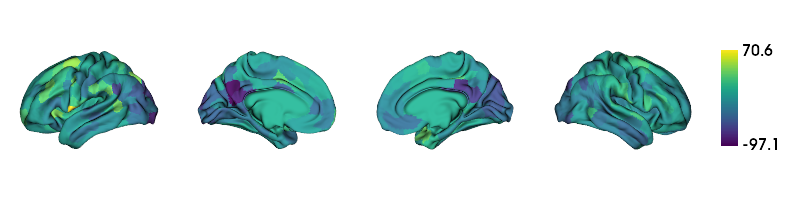

In [18]:
from brainspace.datasets import load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres

# load micapipe parcellated neocortical timeseries
neo_func = np.loadtxt(f'/data/mica3/BIDS_MICs/derivatives/micapipe/sub-{subject}/ses-01/func/surfaces/sub-{subject}_ses-{session}_rsfmri_space-fsnative_atlas-schaefer-400_desc-timeseries.txt')[:,50:].T

# plot (only the first timepoint)
atlas = load_parcellation('schaefer', scale=400, join=True)-1
surf_lh, surf_rh = load_conte69()
mp = np.zeros(surf_lh.n_points + surf_rh.n_points)
for i in range(np.max(atlas)):
    mp[atlas==i] = neo_func[i,0]
plot_hemispheres(surf_lh, surf_rh, array_name=mp, 
     size=(800, 200), color_bar=True, embed_nb=True)

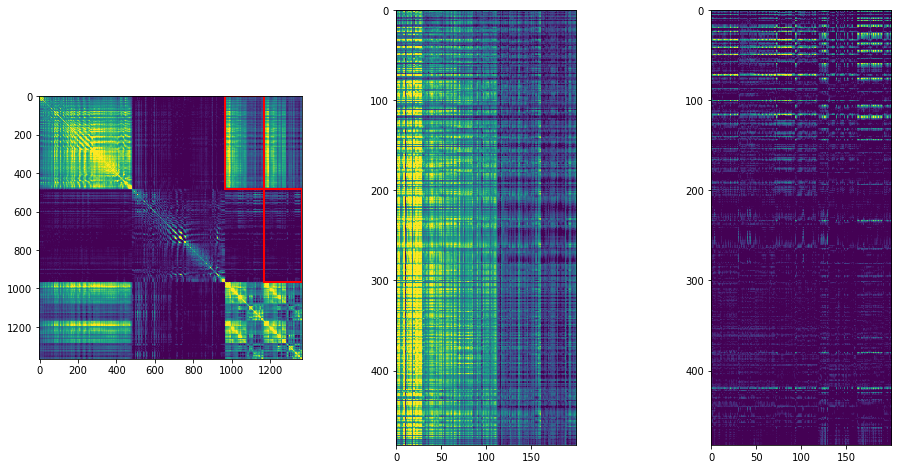

In [19]:
# plot connectivity (left hipp vertices then right hipp vertices then left neocortical parcels then right neocortical parcels)
FC = np.corrcoef(hipp_func,neo_func)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,8))
ax[0].imshow(FC, vmin=0, vmax=0.5)

# view only left-hipp to left-neo and right-hipp to right-neo
nverts = int(len(hipp_func)/2)
nparcs = int(len(neo_func)/2)
import matplotlib.patches as patches
rect = patches.Rectangle((nverts*2, 0), nparcs, nverts, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
rect = patches.Rectangle((nverts*2+nparcs, nverts), nparcs, nverts, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

# separate left and right hippocampi and keep only ipsilateral FCs
FClr = np.zeros((nverts,nparcs,2))
FClr[:,:,0] = FC[      :nverts  , nverts*2       :nverts*2+nparcs]
FClr[:,:,1] = FC[nverts:nverts*2, nverts*2+nparcs:nverts*2+nparcs*2]
ax[1].imshow(FClr[:,:,0], vmin=0, vmax=0.5)
ax[2].imshow(FClr[:,:,1], vmin=0, vmax=0.5)

## 2) Calculate gradients

Here we will use a reference gradient calculated from 88 unrelated HCP subjects. 

If you wish to calculate your own reference gradient then I recommend:
1) Average FC over many subjects (which should lead to no <0 values which are uninterpretable)
2) Use that in a gradient calculation with no reference (you should be able to use low sparsity since we have high confidence in the values and do not wish to discard any)

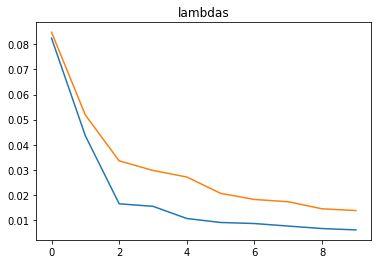

In [20]:
from brainspace.gradient import GradientMaps

ncomponents=10
gradients = np.zeros((nverts,ncomponents,2))
lambdas = np.zeros((ncomponents,2))
for h in range(len(hemi)):
    refgradient = np.load(f'resources/AvgGradient_HCP-UR100_hemi-{hemi[h]}.npy')
    gm = GradientMaps(n_components=ncomponents, kernel='normalized_angle', random_state=0, alignment='procrustes')
    gm.fit(FClr[:,:,h], reference=refgradient)
    gradients[:,:,h] = gm.aligned_
    lambdas[:,h] = gm.lambdas_
plt.plot(lambdas);
plt.title('lambdas');

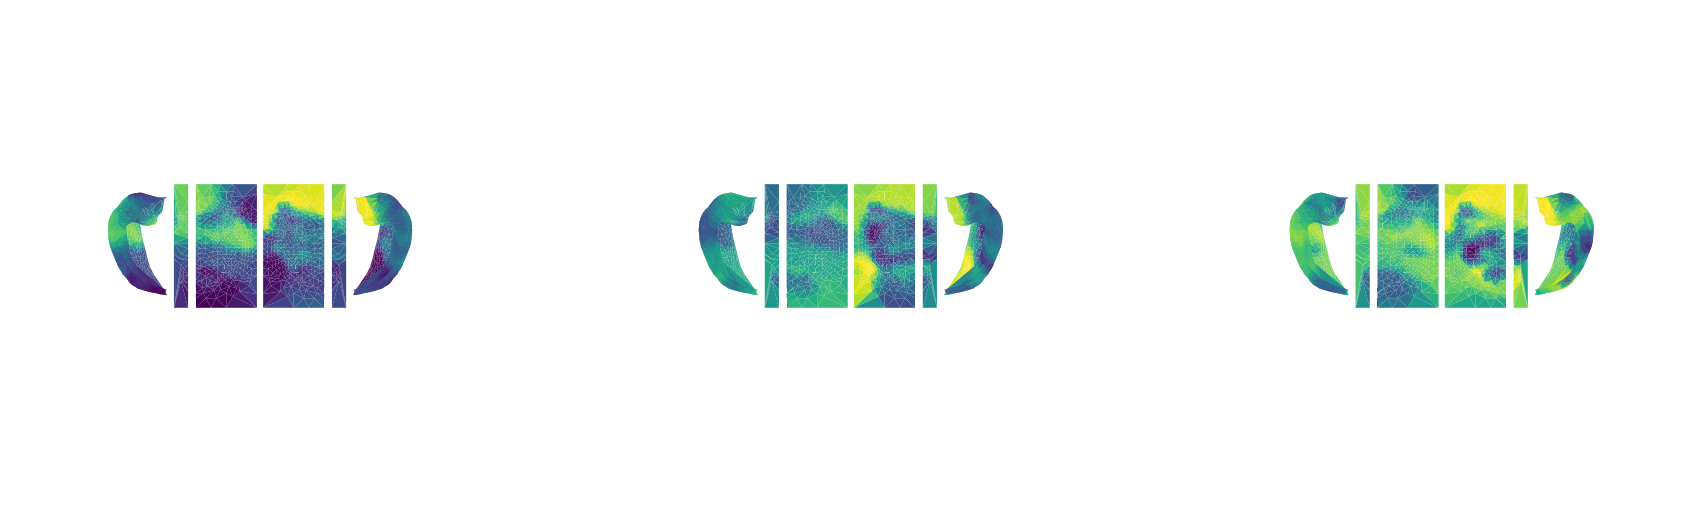

In [21]:
# plot first 3 gradients
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,30), subplot_kw={'projection': "3d"})
for g in range(3):
    plotting.surfplot_canonical_foldunfold(ax[g], np.concatenate((gradients[:,g,0],gradients[:,g,1])), den='2mm')

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


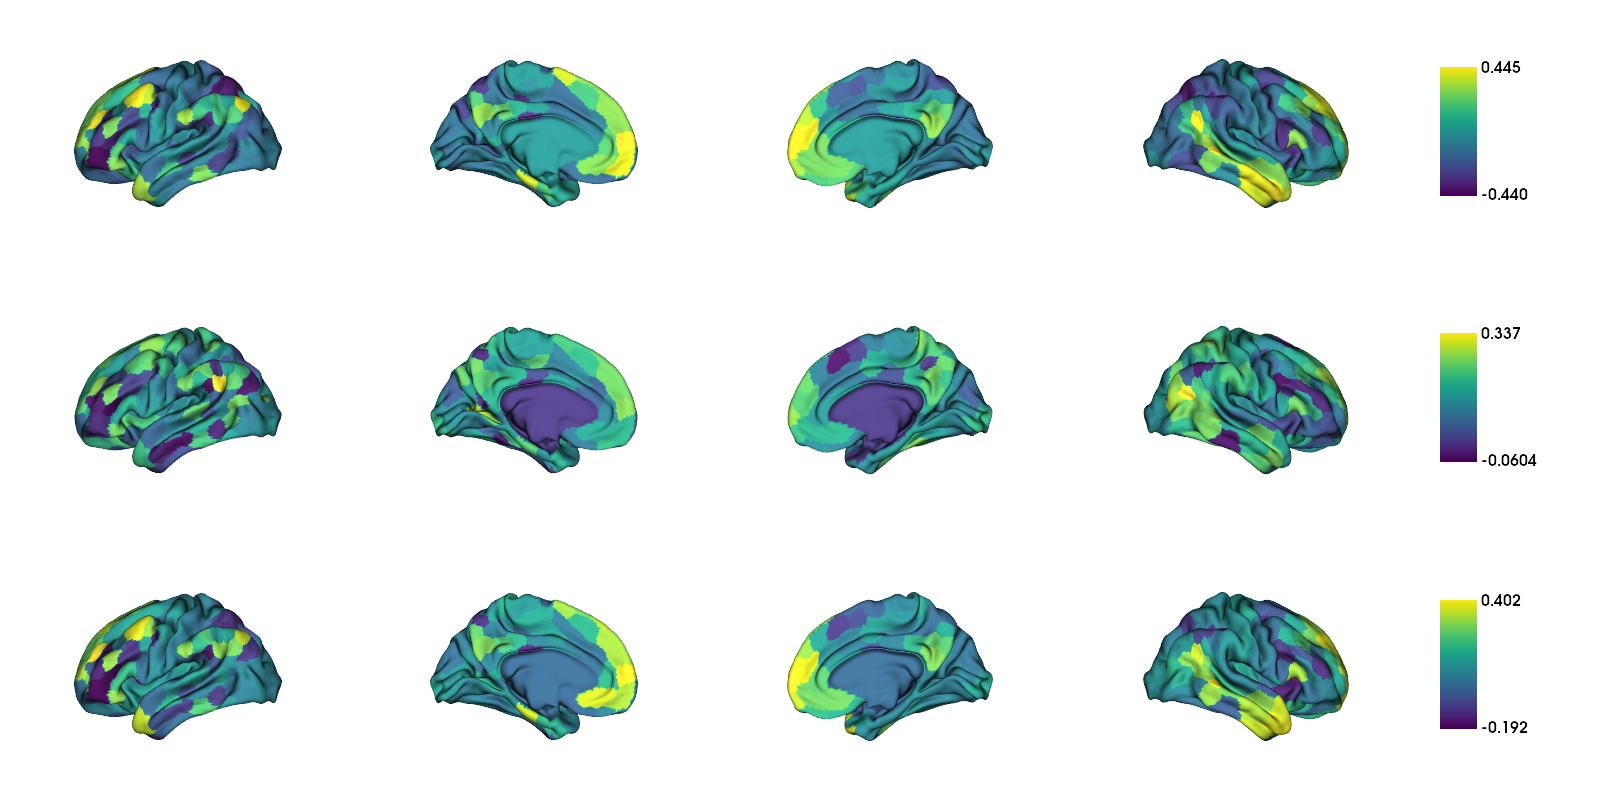

In [22]:
# look only at FC to the rest of the neocortex for the top-bottom 10% of each gradient
nvertsplit = int(nverts*.1)

diffval = np.zeros([surf_lh.n_points + surf_rh.n_points,5])
botval = np.zeros(surf_lh.n_points + surf_rh.n_points)
topval = np.zeros(surf_lh.n_points + surf_rh.n_points)
for g in range(3):
    for lr in range(2):
        bot = np.argpartition(gradients[:,g,lr],nvertsplit)[:nvertsplit]
        top = np.argpartition(gradients[:,g,lr],-nvertsplit)[-nvertsplit:]
        for i in range(np.max(atlas)):
            if i==0:
                botval[atlas==i] = np.mean(FClr[bot,i,0])
                topval[atlas==i] = np.mean(FClr[top,i,0])
            else:
                botval[atlas==i] = np.mean(FClr[bot,i-200,1])
                topval[atlas==i] = np.mean(FClr[top,i-200,1])
        diffval[:,g] = topval-botval

plot_hemispheres(surf_lh, surf_rh, array_name=[diffval[:,0],diffval[:,1],diffval[:,2]], size=(1600, 800), color_bar=True, embed_nb=True)